<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [4]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [5]:
#def ones(x):
#    return int(x/np.timedelta64(1,'s'))
#oss = np.vectorize(ones)

In [6]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    df = np.array([np.zeros(len(feature_names))])
    
    with open(site_freq_path, 'rb') as f: # открытие словоря
        site_dict = pickle.load(f)   
        
    for file in log_progress(os.listdir(path_to_csv_files),every =1): 
        #print(file)
        if file.split('.')[-1] == 'csv': # проверка что фаил формата csv        
        
            user_id = file.split('.')[0][-4:]

            data = pd.read_csv('{}'.format(os.path.join(path_to_csv_files,file)), parse_dates=[1], infer_datetime_format=True)
            temp = pd.DataFrame({'userid': [int(user_id)] * len(data)})
            #print(data.info())
            data = temp.join(data)
            data.timestamp = data.timestamp.apply(pd.to_datetime)
           
            for w in log_progress(range(0, len(data), window_size),every=10):
                session = tuple(data[w:w+session_length].site.apply(lambda x: site_dict[x][0]))        
                session = list(session)  
              
                timestamps = list(data[w:w+session_length].timestamp)
                #timediff = np.array(timestamps[1:len(timestamps)]) - np.array(timestamps[0:-1])
                
                #timediff = oss(timediff)
               # timediff = np.reshape(timediff,(1,len(timediff)))
                session_timespan = (max(timestamps) - min(timestamps)).total_seconds()
                num_unique_sites = len(set(session))
                start_hour = min(timestamps).hour
                day_of_week = min(timestamps).weekday()
                #print(timediff)
                session.extend([0] * (session_length - len(session)))
                #session.extend(timediff)
                #session.extend([0] * (session_length - len(timestamps)))
                session.extend([session_timespan, num_unique_sites, start_hour, day_of_week, user_id])
                
                df = np.concatenate((df, np.array([session])))
                
    df = np.delete(df, 0, 0)
    df = pd.DataFrame(df, columns=feature_names)     
       
    return df

**Проверим функцию на игрушечном примере.**

In [7]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [8]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,7998.0,8,9,4,0001
1,3,1,1,1,0,0,0,0,0,0,60.0,2,12,4,0001
2,3,2,6,6,2,0,0,0,0,0,7935.0,3,9,4,0002
3,4,1,2,1,2,1,1,5,11,4,7998.0,5,9,4,0003
4,4,1,2,0,0,0,0,0,0,0,1471.0,3,12,4,0003


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [9]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 1min 49s


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

Длительность 2:33

In [ ]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [162]:
new_features_10users = train_data_10users[['session_timespan','#unique_sites','start_hour','day_of_week']]
new_features_150users = train_data_150users[['session_timespan','#unique_sites','start_hour','day_of_week']]

In [165]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

Чтение pickle-файлов с признаками session_timespan, #unique_sites, start_hour и day_of_week для 10 и 150 пользователей.

In [10]:
with open(os.path.join(PATH_TO_DATA, 'new_features_10users.pkl'), 'rb') as f:
    new_features_10users = pickle.load(f)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'rb') as f:
    new_features_150users =pickle.load(f)

In [11]:
print("Медиальная продолжительность сессии {}".format(new_features_10users.session_timespan.median()))

Медиальная продолжительность сессии 37.0


**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [12]:
print("Медиальный день начала сессии {}".format(new_features_10users.day_of_week.median()))

Медиальный день начала сессии 2.0


**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [13]:
print("Медиальный час начала сессии {}".format(new_features_150users.start_hour.median()))

Медиальный час начала сессии 13.0


**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [14]:
print("Медиальный час начала сессии {}".format(new_features_150users['#unique_sites'].median()))

Медиальный час начала сессии 7.0


## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
train_data_10users['target'] = train_data_10users['target'].astype(int)

In [16]:
train_data_10users['target'] = train_data_10users['target'].astype(int)
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [17]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

In [18]:
train_data_10users['session_timespan'] =train_data_10users['session_timespan'].astype(float)

Text(0.5,1,'Гистограмма распределения длины сессии в секундах ')

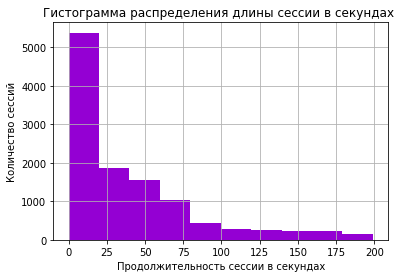

In [19]:
train_data_10users['session_timespan'] =train_data_10users['session_timespan'].astype(float)
train_data_10users[train_data_10users['session_timespan'] < float(200)]['session_timespan'].hist(color='darkviolet')
plt.xlabel('Продолжительность сессии в секундах')
plt.ylabel('Количество сессий')
plt.title('Гистограмма распределения длины сессии в секундах ')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0.5,1,'Гистограмма распределения числа уникальных сайтов в сессии ')

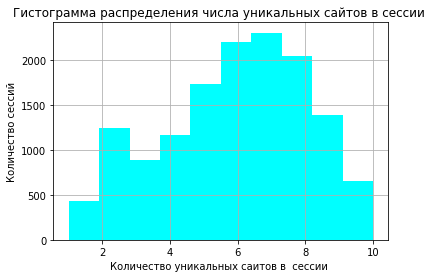

In [20]:
train_data_10users['#unique_sites'] =train_data_10users['#unique_sites'].astype(float)
train_data_10users['#unique_sites'].hist(color ='aqua')
plt.xlabel('Количество уникальных саитов в  сессии ')
plt.ylabel('Количество сессий')
plt.title('Гистограмма распределения числа уникальных сайтов в сессии ')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

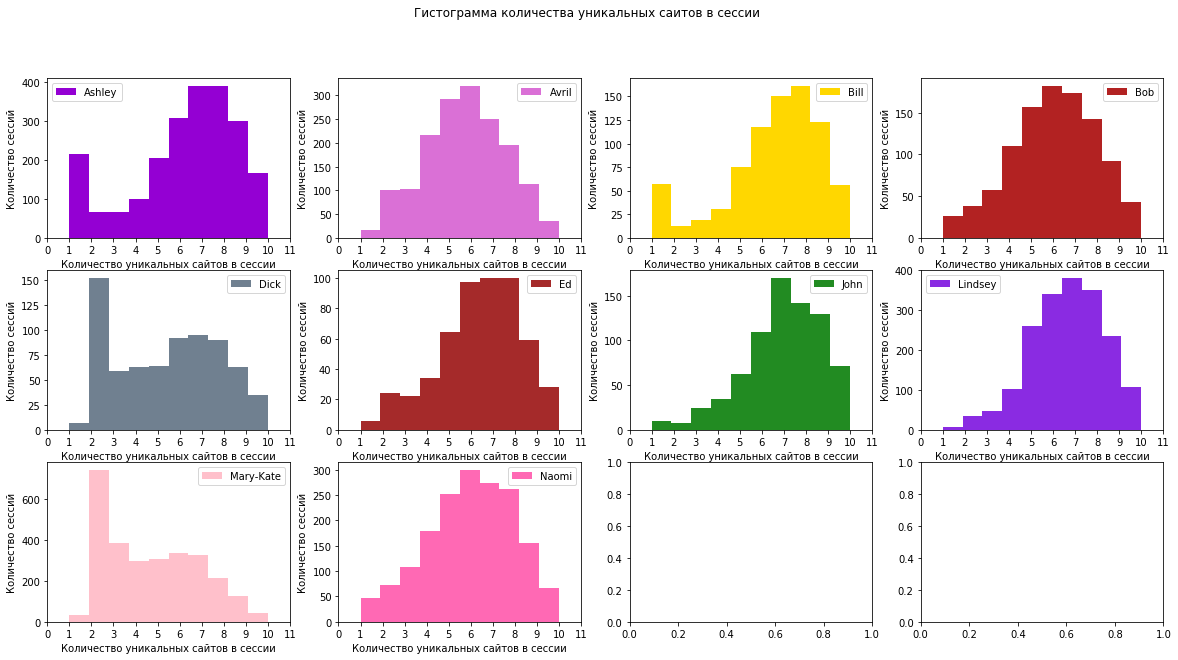

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
plt.suptitle('Гистограмма количества уникальных саитов в сессии')
for idx, (user, sub_df) in  enumerate (pd.groupby(train_data_10users, 'target')):
    a = plt.subplot(3, 4, idx+1)
    plt.hist(sub_df['#unique_sites'], color=color_dic[user], label=user, )
    plt.xlabel('Количество уникальных сайтов в сессии')
    plt.ylabel('Количество сессий')
    a.set_xticks(range(12))
    plt.legend ()  
    
     

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0.5,1,'Гистограмма распределения часа начала сессии')

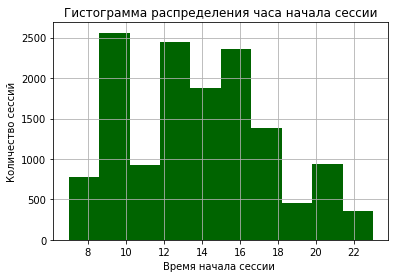

In [22]:
train_data_10users['start_hour'] = train_data_10users['start_hour'].astype(int)
train_data_10users['start_hour'].hist(color='darkgreen')
plt.xlabel('Время начала сессии ')
plt.ylabel('Количество сессий')
plt.title('Гистограмма распределения часа начала сессии')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

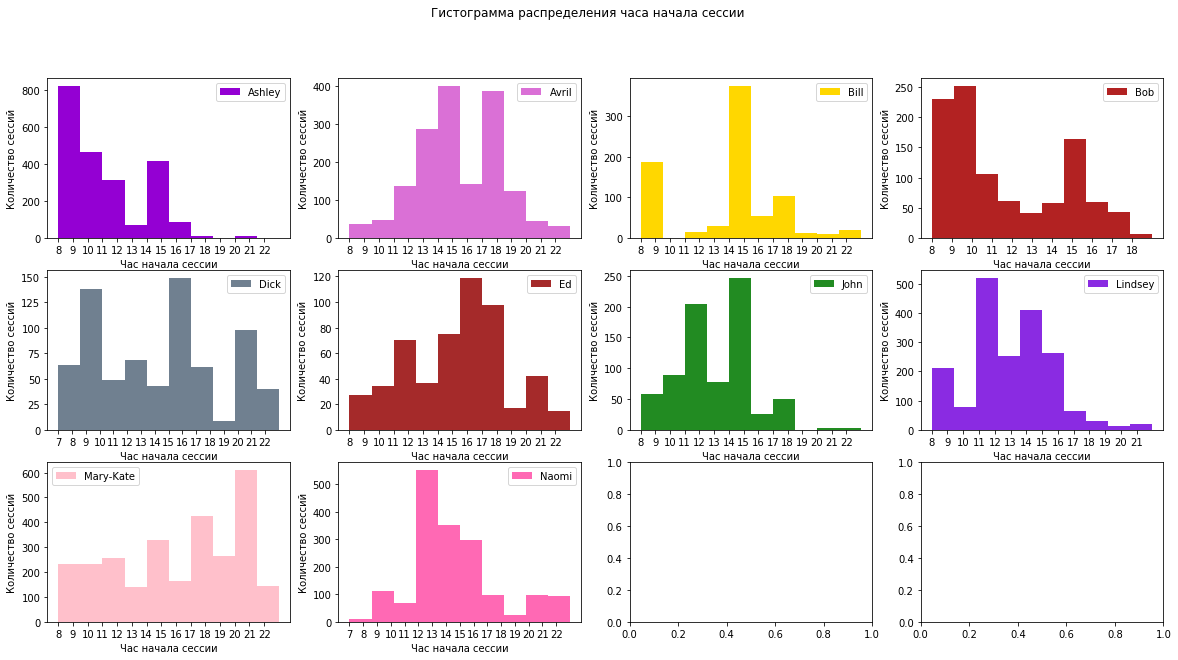

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
plt.suptitle('Гистограмма распределения часа начала сессии')
for idx, (user, sub_df) in  enumerate (pd.groupby(train_data_10users, 'target')):
    a = plt.subplot(3, 4, idx+1)
    plt.hist(sub_df['start_hour'], color=color_dic[user], label=user, )
    plt.xlabel('Час начала сессии')
    plt.ylabel('Количество сессий')
    a.set_xticks(range(int(sub_df['start_hour'].min()),int(sub_df['start_hour'].max())))
    plt.legend ()  

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0.5,1,'Гистограмма распределения дня недели начала сессии')

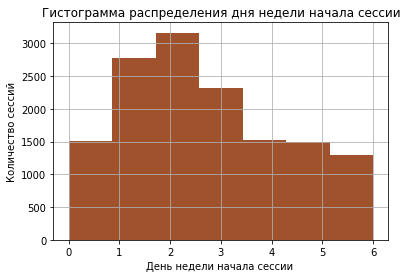

In [24]:
train_data_10users['day_of_week'] = train_data_10users['day_of_week'].astype(int)
train_data_10users['day_of_week'].hist(color='sienna',bins=7)
plt.xlabel('День недели начала сессии ')
plt.ylabel('Количество сессий')
plt.title('Гистограмма распределения дня недели начала сессии')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

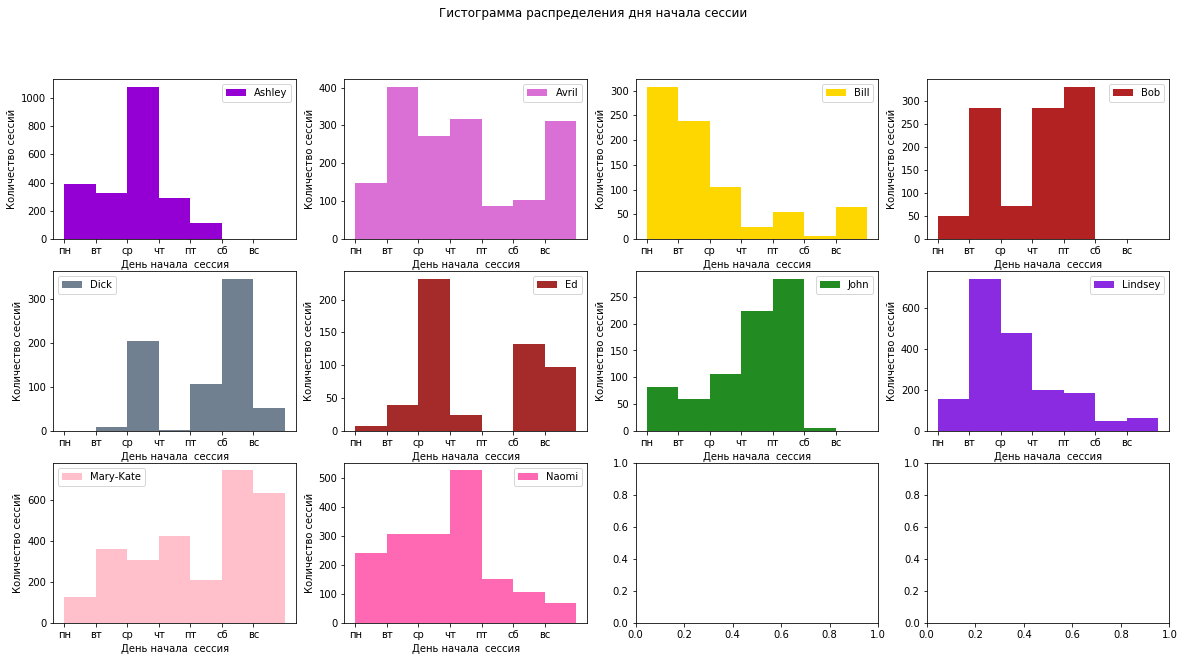

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
plt.suptitle('Гистограмма распределения дня начала сессии')

for idx, (user, sub_df) in  enumerate (pd.groupby(train_data_10users, 'target')):
    a = plt.subplot(3, 4, idx+1)    
    plt.hist(sub_df['day_of_week'], color=color_dic[user], label=user, bins = range(0, 8))
    plt.xlabel('День начала  сессия')
    plt.ylabel('Количество сессий')
    a.set_xticks(range(0, 7))
    a.set_xticklabels(['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])
    plt.legend ()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Mary-Kate 
Дни: премуществено Выходные
Время: вечер
кол-во сайтов: 2

Ashley
Дни: будние дни,премуществено среда.
Время: в утренее время и в районе 15 часов.
кол-во сайтов: в среднем 5-9

Lindsey
Дни: премуществено вторник, среда.
Время: с обеда и до начала ужина.
кол-во сайтов: в среднем 5-9

Naomi
Дни: Пн-Чт,премуществено четверг.
Время: с 12 и до 17 часов.
кол-во сайтов: в среднем 4-9

Avril
Дни: Вт-Чт,Вс.
Время: с 12 до 15, 17 часов.
кол-во сайтов: в среднем 5-8

Bob
Дни: Вт,Чт,Пт.
Время: с 8 до 10 ,  15 часов.
кол-во сайтов: в среднем 5-8
Bill
Дни: Пн, Вт
Время: 8, 15 часов.
кол-во сайтов: в среднем 6-9

John
Дни: Чт,Пт.
Время: 12 и  15 часов.
кол-во сайтов: в среднем 6-9

Dick
Дни: Сб.
Время: 8 и 16.
кол-во сайтов: в среднем 2

Ed
Дни: премуществено среда.
Время: 15-16.
кол-во сайтов: в среднем 6-8

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [26]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq_10users = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [27]:
top10_freqs = [list(site_freq_10users.values())[v][1] for v in range(10)]
top10_sites = [list(site_freq_10users.keys())[k] for k in range(10)]

In [28]:
top10_freqs

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

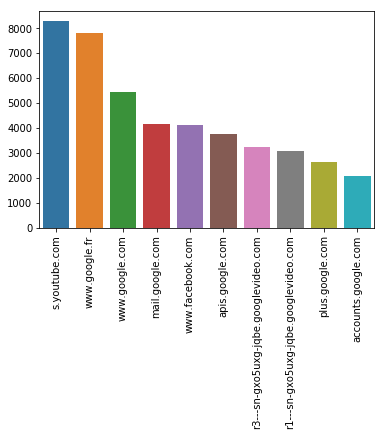

In [29]:
sns.barplot(y=top10_freqs,x=top10_sites)
plt.xticks(rotation='vertical')

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [30]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    start_mounth = np.array([])
    for file in log_progress(os.listdir(path_to_csv_files),every =1): 
        
        if file.split('.')[-1] == 'csv': # проверка что фаил формата csv   
            df = pd.read_csv('{}'.format(os.path.join(path_to_csv_files,file)), parse_dates=[1], infer_datetime_format=True)
            indx =list()
            for i in range(0,df.shape[0],10):
                indx.append(i)
            
            if df.shape[0] % session_length == 0:
                mounth = df.timestamp.values[indx]
            elif df.shape[0] < session_length:
                mounth = df.timestamp.values[0]
            else:
                mounth = np.append(df.timestamp.values[indx],df.timestamp.values[df.shape[0] // 10])
            
            start_mounth = np.append(start_mounth,mounth)        
    return pd.DataFrame(data=start_mounth, columns=[features])

In [31]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'),
                  'start_month', session_length=10) 

In [32]:
new_features_10users.head()

,start_month
0,2013-11-15 08:12:07
1,2013-11-15 08:12:40
2,2013-11-15 08:17:25
3,2013-11-15 08:21:43
4,2013-11-15 08:22:13


In [33]:
new_features_10users['start_month'] =new_features_10users['start_month'].apply(lambda x: np.datetime64(x))
new_features_10users['start_month'] = new_features_10users['start_month'].apply(lambda ts: 100 * ts.year + ts.month).astype('str')


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

Text(0.5,1,'Активность пользователей')

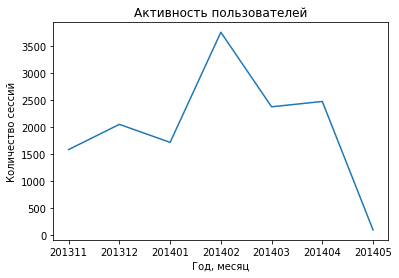

In [34]:
plt.plot(new_features_10users.groupby('start_month').size())
plt.xlabel('Год, месяц')
plt.ylabel('Количество сессий')
plt.title('Активность пользователей')

Наиболюшую активность пользователи проявляли в феврале 2014г. С апреля по май 2014 спад активности(смена парадигмы поведения пользователей?)

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 